## Analyse the results



In [1]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils, fit_el_utils
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils
import emcee
import pandas as pd
import glob
from pl_temp_fit import Emcee_utils
os.chdir("/media/mohammed/Work/Work/pl_temp_fit/")
# access the right directory
# os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [13]:


databse_path = Path("fit_experimental_emcee_pl/fit_data_base/")
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for _id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )
    if os.path.exists(model_config_save["save_folder"] + "/sampler.h5"):
        filename = model_config_save["save_folder"] + "/sampler.h5"
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            if not reader.initialized:
                print("multi_core empty file")
                continue
            if reader.iteration == 0:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)
        except AttributeError as e:
            print("check if single core")

            reader = emcee.backends.HDFBackend(filename, name="single_core")
            if not reader.initialized:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)

        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)

        list_model_config.append(model_config_save)
if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,/media/mohammed/Work/Work/pl_temp_fit/experiem...,300,-39.915613


In [17]:
index_analyse = 0
test_id = df_all["test_id"].loc[index_analyse]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=databse_path
)
filename = model_config_save["save_folder"] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

number of iterations 300
-39.91561300272554


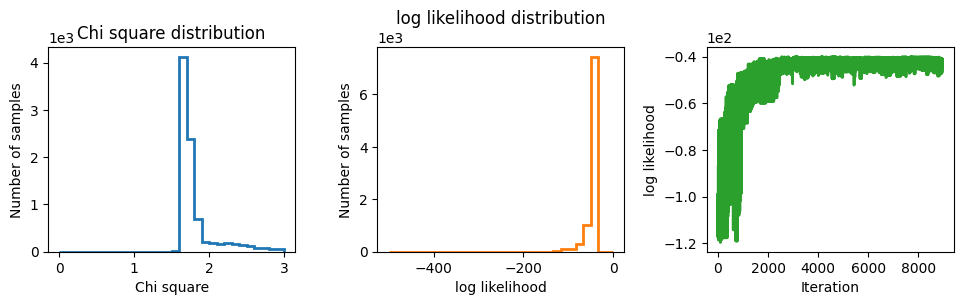

In [18]:
from pl_temp_fit import plot_utils
import importlib

importlib.reload(plot_utils)
plot_utils.plot_fit_statistics(
    reader,
    range_log_prior=(-500, 0),
    discard=0,
    range_chi_square=(0, 3),
    filter_log_likelihood=True,
)

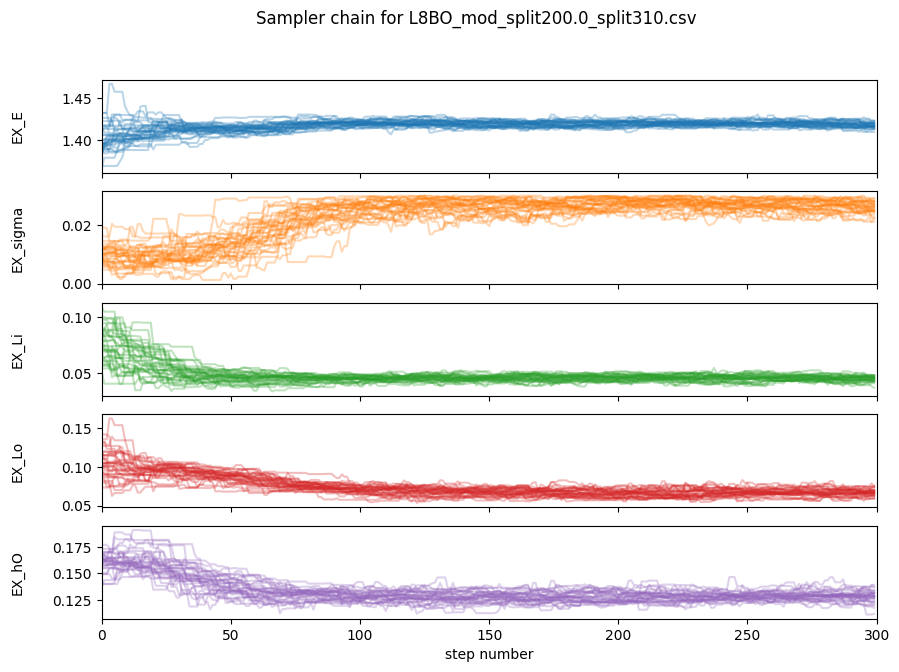

In [19]:
plot_utils.plot_chains(reader, model_config_save, discard=0)

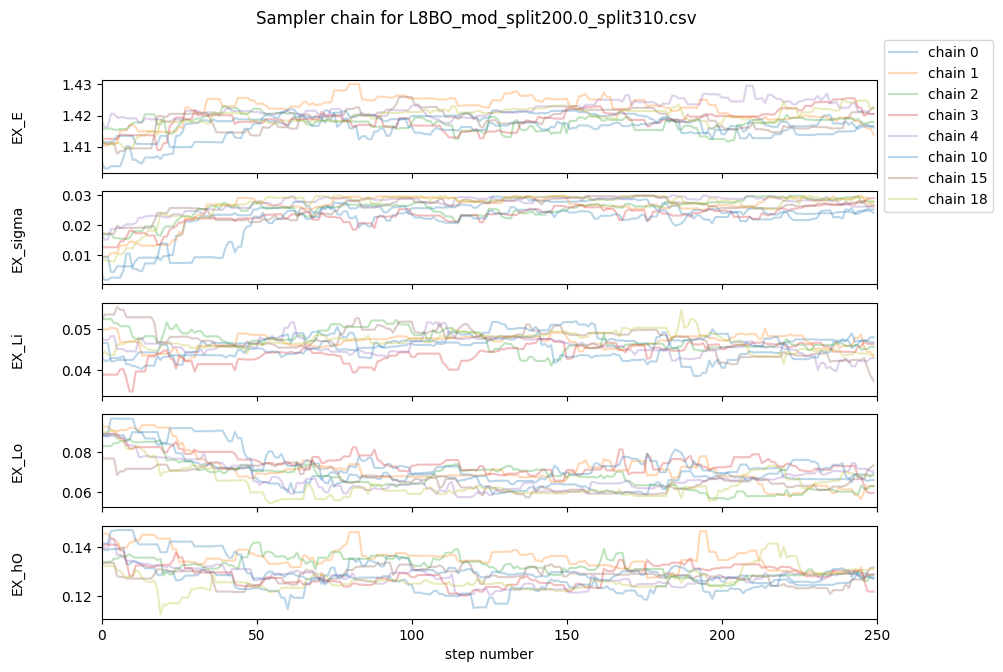

In [23]:
plot_utils.plot_diff_chains(
    reader,
    model_config_save,
    discard=50,
    chains_list=[0, 1, 2, 3, 4, 10, 15, 18],
)

(1.0, 1.6)

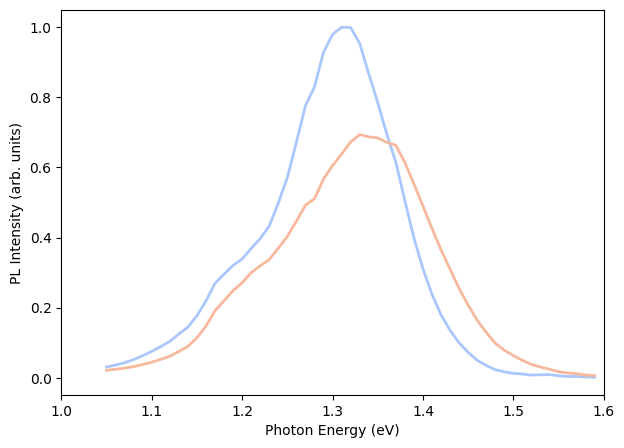

In [21]:
def plot_pl_data(
    truemodel_pl, temperature_list, hws, title="Experimental Data"
):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    data_true_plot = truemodel_pl.reshape(len(hws), -1) / max(
        truemodel_pl.reshape(-1, 1)
    )
    import seaborn as sns

    color_list = sns.color_palette("coolwarm", len(temperature_list))
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            data_true_plot[:, i],
            label="" + str(temperature_list[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )

    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel("PL Intensity (arb. units)")

    return fig, ax


csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig, ax = plot_pl_data(
    Exp_data, temperature_list, hws, title="Experimental Data"
)
ax.set_xlim(1, 1.6)

shape of mean value plot is (55, 2)


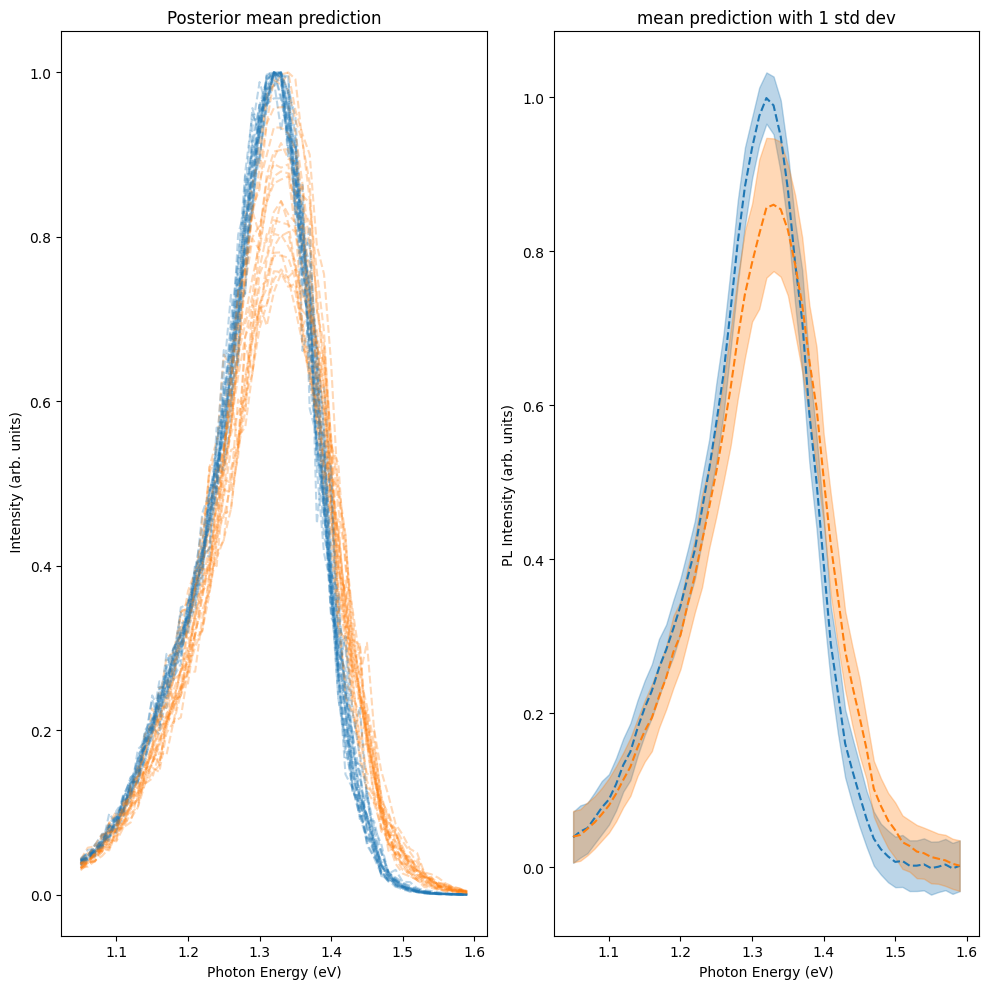

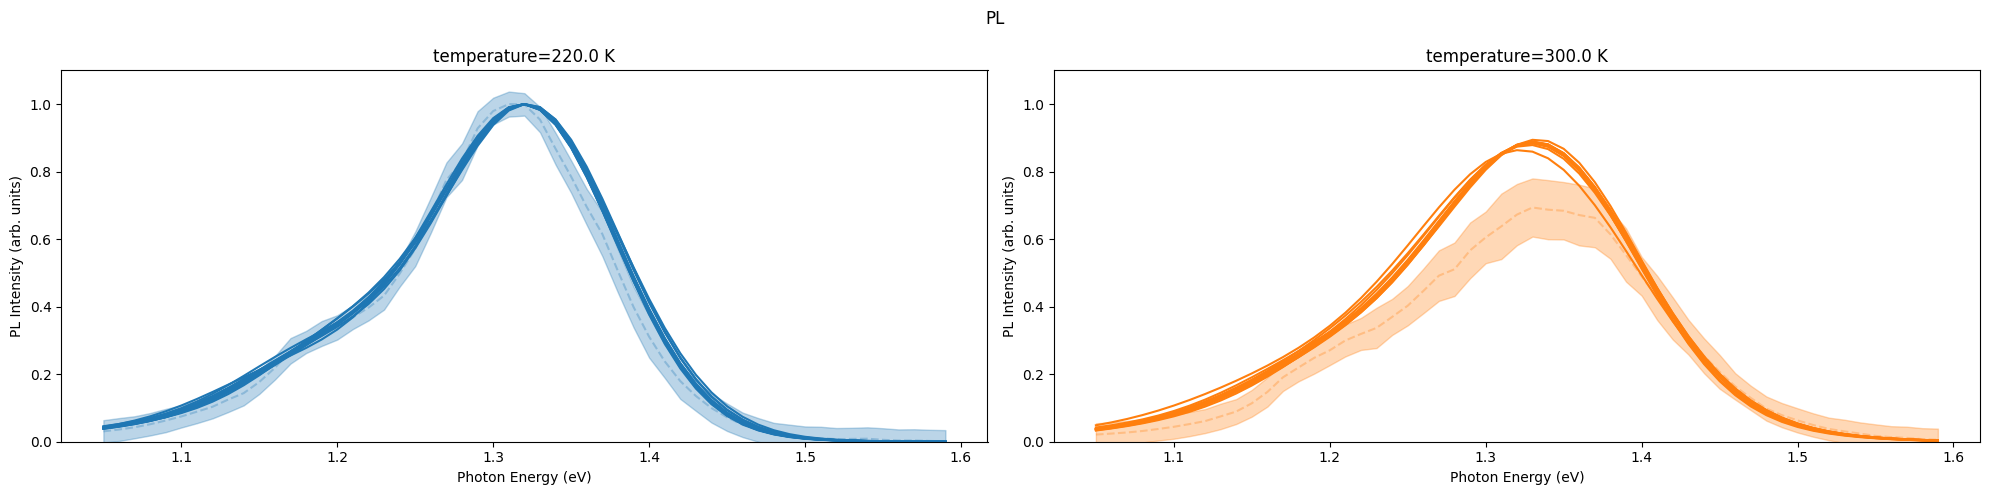

In [24]:
plot_utils.plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=50,
    filter_log_likelihood=False,
)

(<Figure size 1000x700 with 5 Axes>,
 array([<Axes: ylabel='EX_E'>, <Axes: ylabel='EX_sigma'>,
        <Axes: ylabel='EX_Li'>, <Axes: ylabel='EX_Lo'>,
        <Axes: ylabel='EX_hO'>], dtype=object))

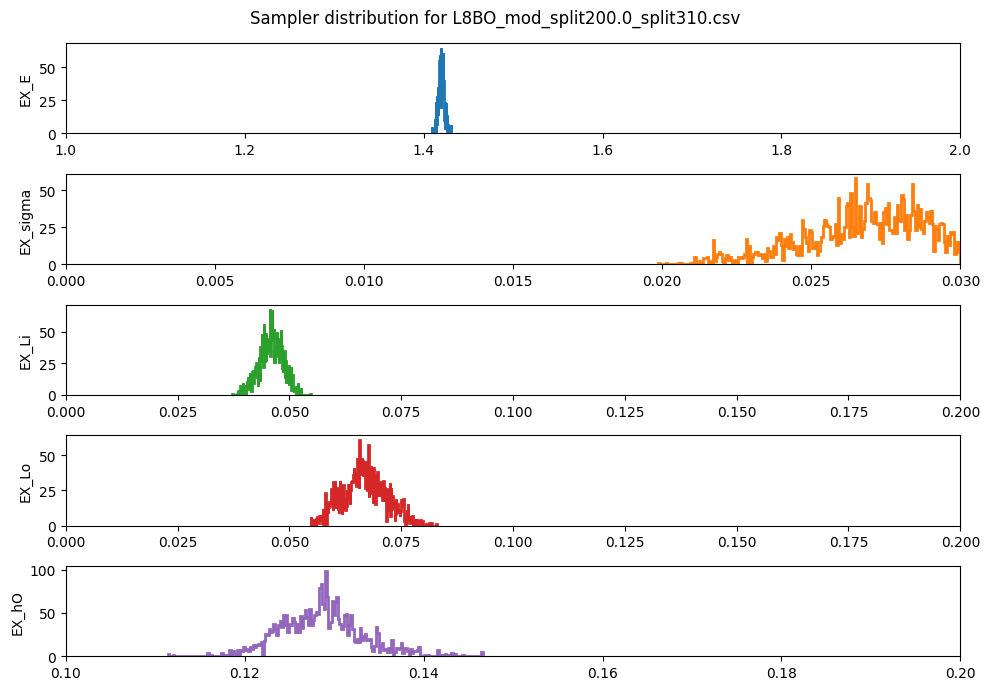

In [26]:
importlib.reload(plot_utils)
plot_utils.plot_distribution(
    reader, model_config_save, discard=200, filter_log_likelihood=True
)

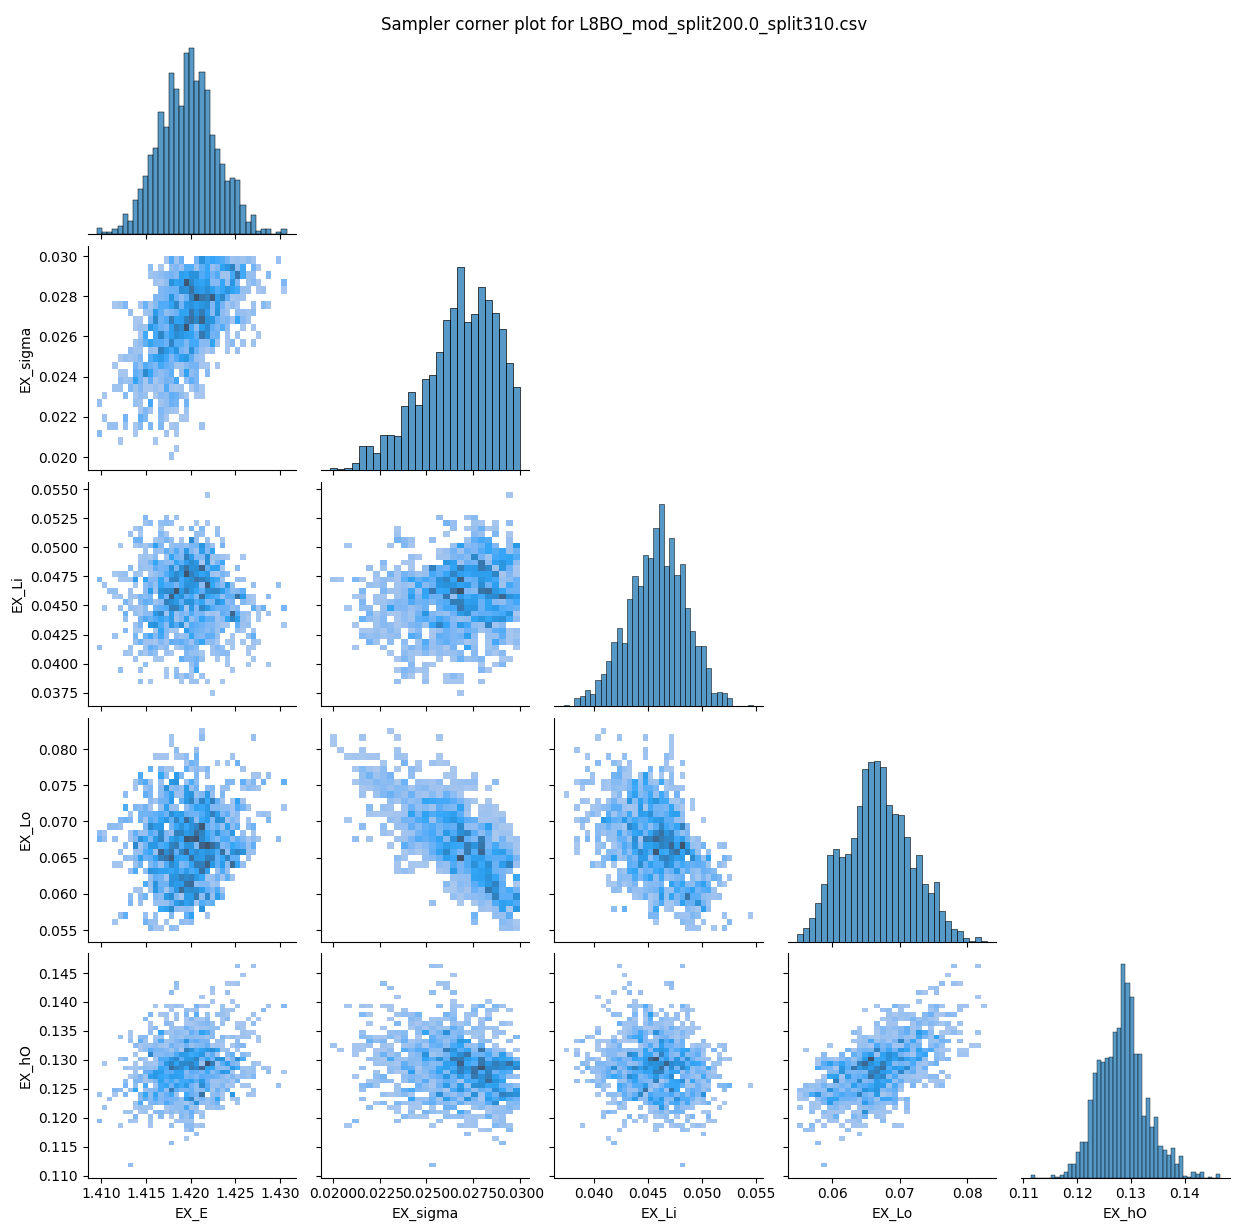

In [27]:
plot_utils.plot_corner(
    reader, model_config_save, discard=200, filter_log_likelihood=True
)

number of iterations 300


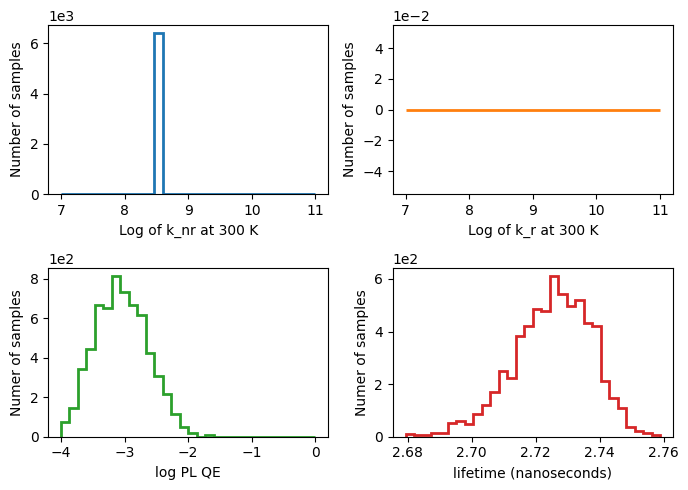

In [28]:
plot_utils.plot_lifetime(reader, discard=100, filter_log_likelihood=True)

number of iterations 300
-39.91561300272554


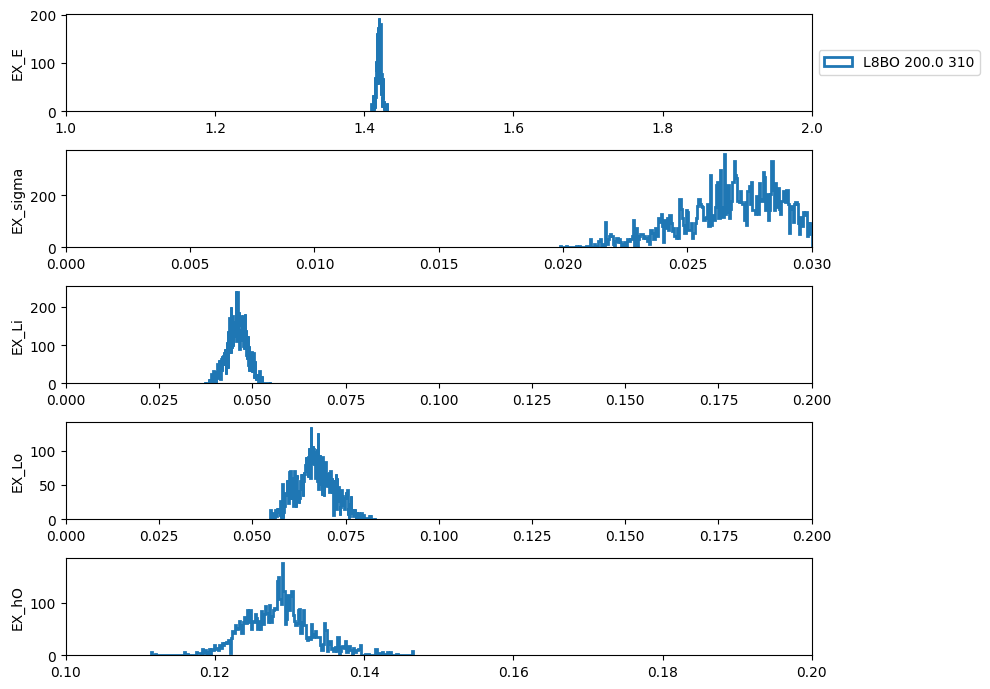

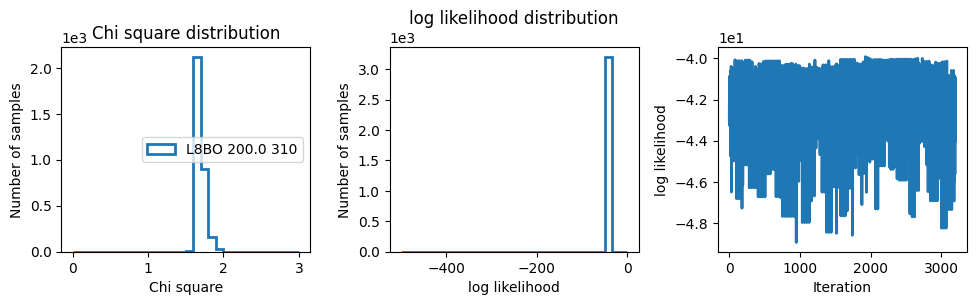

In [33]:
import importlib

importlib.reload(plot_utils)
index_analyse_list = [0]
fig, axes = plt.subplots(5, figsize=(10, 7))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_pl"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_distribution_multi(
        reader,
        model_config_save,
        discard=200,
        filter_log_likelihood=True,
        fig=fig,
        axes=axes,
        color=f"C{i}",
        legend_label=label,
    )
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_pl"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_fit_statistics_multi(
        reader,
        range_log_prior=(-500, 0),
        discard=200,
        range_chi_square=(0, 3),
        filter_log_likelihood=True,
        fig=fig,
        ax=ax,
        legend_label=label,
        color=f"C{i}",
    )